### Configuration: number of files and ServiceX usage

In [1]:
# GLOBAL CONFIGURATION
N_FILES_MAX_PER_SAMPLE = 10  # input files per process, set to -1 for no limit / 1 or 10 for quick debugging
USE_SERVICEX = False
USE_DASK = True
SERVICEX_IGNORE_CACHE = False  # set to True to force re-running of transforms
AF = "coffea_casa"  # set to "coffea_casa" for coffea-casa environments, "EAF" for FNAL, "local" for local setups

### relevant imports

In [2]:
import asyncio
import time

import awkward as ak
import vector
from coffea import processor
from coffea.processor import servicex
import hist
import json
import numpy as np
import uproot
import cabinetry
from func_adl_servicex import ServiceXSourceUpROOT
from func_adl import ObjectStream
from servicex import ServiceXDataset
from coffea.nanoevents.schemas.base import BaseSchema
import matplotlib.pyplot as plt

import utils

vector.register_awkward()

### coffea Processor

In [3]:
processor_base = processor.ProcessorABC if not USE_SERVICEX else servicex.Analysis

# functions creating systematic variations
def flat_variation(ones):
    # 5% weight variations
    return (1.0 + np.array([0.05, -0.05], dtype=np.float32)) * ones[:, None]


def btag_weight_variation(i_jet, jet_pt):
    # weight variation depending on i-th jet pT (10% as default value, multiplied by i-th jet pT / 50 GeV)
    return 1 + np.array([0.1, -0.1]) * (ak.singletons(jet_pt[:, i_jet]) / 50).to_numpy()


class TtbarAnalysis(processor_base):
    def __init__(self):
        num_bins = 25
        bin_low = 50
        bin_high = 550
        name = "observable"
        label = "observable [GeV]"
        self.hist = (
            hist.Hist.new.Reg(num_bins, bin_low, bin_high, name=name, label=label)
            .StrCat(["4j1b", "4j2b"], name="region", label="Region")
            .StrCat([], name="process", label="Process", growth=True)
            .StrCat([], name="variation", label="Systematic variation", growth=True)
            .Weight()
        )

    def process(self, events):
        histogram = self.hist.copy()

        process = events.metadata["process"]  # "ttbar" etc.
        variation = events.metadata["variation"]  # "nominal" etc.

        # normalization for MC
        x_sec = events.metadata["xsec"]
        nevts_total = events.metadata["nevts"]
        lumi = 3378 # /pb
        if process != "data":
            xsec_weight = x_sec * lumi / nevts_total
        else:
            xsec_weight = 1
        
        #### systematics
        if process == "ttbar":
            # TODO: not currently used
            events.add_systematic("scale_var", "UpDownSystematic", "weight", flat_variation)
            
        def jet_pt_resolution(pt):
            # normal distribution with 5% variations, shape matches jets
            counts = ak.num(pt)
            pt_flat = ak.flatten(pt)
            resolution_variation = np.random.normal(np.ones_like(pt_flat), 0.05)
            return ak.unflatten(resolution_variation, counts)

        # jet energy scale / resolution systematics
        # need to adjust schema to instead use coffea add_systematic feature, especially for ServiceX
        # cannot attach pT variations to events.jet, so attach to events directly
        # and subsequently scale pT by these scale factors
        events["pt_nominal"] = 1.0
        events["pt_scale_up"] = 1.05
        events["pt_res_up"] = jet_pt_resolution(events.jet.pt)
                
        pt_variations = ["pt_nominal", "pt_scale_up", "pt_res_up"] if variation == "nominal" else ["pt_nominal"]
        for pt_var in pt_variations:
    
            ### event selection
            # very very loosely based on https://arxiv.org/abs/2006.13076

            # pT > 25 GeV for leptons & jets
            selected_electrons = events.electron[events.electron.pt > 25]
            selected_muons = events.muon[events.muon.pt > 25]
            jet_filter = events.jet.pt * events[pt_var] > 25  # pT > 25 GeV for jets (scaled by systematic variations)
            selected_jets = events.jet[jet_filter]  

            # single lepton requirement
            event_filters = (ak.count(selected_electrons.pt, axis=1) & ak.count(selected_muons.pt, axis=1) == 1)
            # at least four jets
            pt_var_modifier = events[pt_var] if "res" not in pt_var else events[pt_var][jet_filter]
            event_filters = event_filters & (ak.count(selected_jets.pt * pt_var_modifier, axis=1) >= 4)
            # at least one b-tagged jet ("tag" means score above threshold)
            B_TAG_THRESHOLD = 0.5
            event_filters = event_filters & (ak.sum(selected_jets.btag >= B_TAG_THRESHOLD, axis=1) >= 1)

            # apply event filters
            selected_events = events[event_filters]
            selected_electrons = selected_electrons[event_filters]
            selected_muons = selected_muons[event_filters]
            selected_jets = selected_jets[event_filters]

            for region in ["4j1b", "4j2b"]:
                # further filtering: 4j1b CR with single b-tag, 4j2b SR with two or more tags
                if region == "4j1b":
                    region_filter = ak.sum(selected_jets.btag >= B_TAG_THRESHOLD, axis=1) == 1
                    selected_jets_region = selected_jets[region_filter]
                    # use HT (scalar sum of jet pT) as observable
                    pt_var_modifier = events[event_filters][region_filter][pt_var] if "res" not in pt_var else events[pt_var][jet_filter][event_filters][region_filter]
                    observable = ak.sum(selected_jets_region.pt * pt_var_modifier, axis=-1)

                elif region == "4j2b":
                    region_filter = ak.sum(selected_jets.btag > B_TAG_THRESHOLD, axis=1) >= 2
                    selected_jets_region = selected_jets[region_filter]

                    if USE_SERVICEX:
                        # wrap into a four-vector object to allow addition
                        selected_jets_region = ak.zip(
                            {
                                "pt": selected_jets_region.pt, "eta": selected_jets_region.eta, "phi": selected_jets_region.phi,
                                "mass": selected_jets_region.mass, "btag": selected_jets_region.btag,
                            },
                            with_name="Momentum4D",
                        )

                    # reconstruct hadronic top as bjj system with largest pT
                    # the jet energy scale / resolution effect is not propagated to this observable at the moment
                    trijet = ak.combinations(selected_jets_region, 3, fields=["j1", "j2", "j3"])  # trijet candidates
                    trijet["p4"] = trijet.j1 + trijet.j2 + trijet.j3  # calculate four-momentum of tri-jet system
                    trijet["max_btag"] = np.maximum(trijet.j1.btag, np.maximum(trijet.j2.btag, trijet.j3.btag))
                    trijet = trijet[trijet.max_btag > B_TAG_THRESHOLD]  # require at least one-btag in trijet candidates
                    # pick trijet candidate with largest pT and calculate mass of system
                    trijet_mass = trijet["p4"][ak.argmax(trijet.p4.pt, axis=1, keepdims=True)].mass
                    observable = ak.flatten(trijet_mass)

                ### histogram filling
                if pt_var == "pt_nominal":
                    # nominal pT, but including 2-point systematics
                    histogram.fill(
                            observable=observable, region=region, process=process, variation=variation, weight=xsec_weight
                        )
        
                    if variation == "nominal":
                        # also fill weight-based variations for all nominal samples
                        for weight_name in events.systematics.fields:
                            for direction in ["up", "down"]:
                                # extract the weight variations and apply all event & region filters
                                weight_variation = events.systematics[weight_name][direction][f"weight_{weight_name}"][event_filters][region_filter]
                                # fill histograms
                                histogram.fill(
                                    observable=observable, region=region, process=process, variation=f"{weight_name}_{direction}", weight=xsec_weight*weight_variation
                                )

                        # calculate additional systematics: b-tagging variations
                        for i_var, weight_name in enumerate([f"btag_var_{i}" for i in range(4)]):
                            for i_dir, direction in enumerate(["up", "down"]):
                                # create systematic variations that depend on object properties (here: jet pT)
                                weight_variation = btag_weight_variation(i_var, selected_jets_region.pt)[:, 1-i_dir]
                                histogram.fill(
                                    observable=observable, region=region, process=process, variation=f"{weight_name}_{direction}", weight=xsec_weight*weight_variation
                                )

                elif variation == "nominal":
                    # pT variations for nominal samples
                    histogram.fill(
                            observable=observable, region=region, process=process, variation=pt_var, weight=xsec_weight
                        )

        output = {"nevents": {events.metadata["dataset"]: len(events)}, "hist": histogram}

        return output

    def postprocess(self, accumulator):
        return accumulator

### AGC schema (for pure coffea)

In [4]:
from coffea.nanoevents.schemas.base import BaseSchema, zip_forms
from coffea.nanoevents.methods import base, vector
from coffea.nanoevents import transforms


# https://github.com/mat-adamec/agc_coffea/blob/main/agc_schema.py
class AGCSchema(BaseSchema):
    def __init__(self, base_form):
        super().__init__(base_form)
        self._form["contents"] = self._build_collections(self._form["contents"])

    def _build_collections(self, branch_forms):
        names = set([k.split('_')[0] for k in branch_forms.keys() if not (k.startswith('number'))])
        # Remove n(names) from consideration. It's safe to just remove names that start with n, as nothing else begins with n in our fields.
        # Also remove GenPart, PV and MET because they deviate from the pattern of having a 'number' field.
        names = [k for k in names if not (k.startswith('n') | k.startswith('met') | k.startswith('GenPart') | k.startswith('PV'))]
        output = {}
        for name in names:
            offsets = transforms.counts2offsets_form(branch_forms['number' + name])
            content = {k[len(name)+1:]: branch_forms[k] for k in branch_forms if (k.startswith(name + "_") & (k[len(name)+1:] != 'e'))}
            # Add energy separately so its treated correctly by the p4 vector.
            content['energy'] = branch_forms[name+'_e']
            # Check for LorentzVector
            output[name] = zip_forms(content, name, 'PtEtaPhiELorentzVector', offsets=offsets)

        # Handle GenPart, PV, MET. Note that all the nPV_*'s should be the same. We just use one.
        output['met'] = zip_forms({k[len('met')+1:]: branch_forms[k] for k in branch_forms if k.startswith('met_')}, 'met')
        #output['GenPart'] = zip_forms({k[len('GenPart')+1:]: branch_forms[k] for k in branch_forms if k.startswith('GenPart_')}, 'GenPart', offsets=transforms.counts2offsets_form(branch_forms['numGenPart']))
        output['PV'] = zip_forms({k[len('PV')+1:]: branch_forms[k] for k in branch_forms if (k.startswith('PV_') & ('npvs' not in k))}, 'PV', offsets=transforms.counts2offsets_form(branch_forms['nPV_x']))
        return output

    @property
    def behavior(self):
        behavior = {}
        behavior.update(base.behavior)
        behavior.update(vector.behavior)
        return behavior

### metadata & fileset construction

In [5]:
fileset = utils.construct_fileset(N_FILES_MAX_PER_SAMPLE, use_xcache=False)

print(f"processes in fileset: {list(fileset.keys())}")
print(f"\nexample of information in fileset:\n{{\n  'files': [{fileset['ttbar__nominal']['files'][0]}, ...],")
print(f"  'metadata': {fileset['ttbar__nominal']['metadata']}\n}}")

processes in fileset: ['ttbar__nominal', 'ttbar__scaledown', 'ttbar__scaleup', 'ttbar__ME_var', 'ttbar__PS_var', 'single_top_s_chan__nominal', 'single_top_t_chan__nominal', 'single_top_tW__nominal', 'wjets__nominal']

example of information in fileset:
{
  'files': [https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/00DF0A73-17C2-E511-B086-E41D2D08DE30.root, ...],
  'metadata': {'process': 'ttbar', 'variation': 'nominal', 'nevts': 442122, 'xsec': 729.84}
}


### ServiceX-specific functionality: datasource construction, query, asyncio
(move to utils file)

In [6]:
def make_datasource(fileset:dict, name: str, query: ObjectStream, ignore_cache: bool):
    """Creates a ServiceX datasource for a particular ATLAS Open data file."""
    datasets = [ServiceXDataset(fileset[name]["files"], backend_name="uproot", ignore_cache=ignore_cache)]
    return servicex.DataSource(
        query=query, metadata=fileset[name]["metadata"], datasets=datasets
    )

def get_query(source: ObjectStream) -> ObjectStream:
    """Query for event / column selection: no filter, select all columns
    """
    return source.Select(lambda e: {
                                    "electron_pt": e.electron_pt,
                                    "muon_pt": e.muon_pt,
                                    "jet_e": e.jet_e,
                                    "jet_pt": e.jet_pt,
                                    "jet_px": e.jet_px,
                                    "jet_py": e.jet_py,
                                    "jet_pz": e.jet_pz,
                                    "jet_eta": e.jet_eta,
                                    "jet_phi": e.jet_phi,
                                    "jet_mass": e.jet_mass,
                                    "jet_btag": e.jet_btag,
                                   }
                        )


async def produce_all_histograms(fileset, use_dask=False):
    """Runs the histogram production, processing input files with ServiceX and
    producing histograms with coffea.
    """
    # create the query
    ds = ServiceXSourceUpROOT("cernopendata://dummy", "events", backend_name="uproot")
    ds.return_qastle = True
    data_query = get_query(ds)

    # EXECUTOR: local vs Dask
    if not use_dask:
        executor = servicex.LocalExecutor()
    else:
        executor = servicex.DaskExecutor(client_addr="tls://localhost:8786")

    datasources = [
        make_datasource(fileset, ds_name, data_query, ignore_cache=SERVICEX_IGNORE_CACHE)
        for ds_name in fileset.keys()
    ]

    # create the analysis processor
    analysis_processor = TtbarAnalysis()

    async def run_updates_stream(accumulator_stream, name):
        """Run to get the last item in the stream"""
        coffea_info = None
        try:
            async for coffea_info in accumulator_stream:
                pass
        except Exception as e:
            raise Exception(f"Failure while processing {name}") from e
        return coffea_info

    all_histogram_dicts = await asyncio.gather(
        *[
            run_updates_stream(
                executor.execute(analysis_processor, source),
                f"{source.metadata['process']}__{source.metadata['variation']}",
            )
            for source in datasources
        ]
    )
    all_histograms = sum([h["hist"] for h in all_histogram_dicts])
    
    return all_histograms

### via servicex-databinder (separate ServiceX + coffea)

In [7]:
from servicex_databinder import DataBinder
query_string = """Select(lambda e: {
                    'electron_pt': e.electron_pt,
                    'jet_e': e.jet_e,
                    'jet_pt': e.jet_pt,
                    'jet_px': e.jet_px,
                    'jet_py': e.jet_py,
                    'jet_pz': e.jet_pz,
                    'jet_eta': e.jet_eta,
                    'jet_phi': e.jet_phi,
                    'jet_mass': e.jet_mass,
                    'jet_btag': e.jet_btag})"""

# from servicex_databinder import DataBinder

databinder_config = {"General": {"ServiceXBackendName": "uproot",
                                 "OutputDirectory": "outputs",
                                 "OutputFormat": "parquet",
                                 "IgnoreServiceXCache": True},
                     "Sample": [
                         {
                             "Name": "single_top_s_chan__nominal",
                             "RucioDID": "user.ivukotic:user.ivukotic.single_top_s_chan__nominal",
                             "Tree": "events",
                             "FuncADL": query_string
                         }
                     ]
                    }

# sx_db = DataBinder(databinder_config)
# out = sx_db.deliver()

# update list of fileset files, pointing to ServiceX output
# for process in fileset.keys():
#     fileset[process]["files"] = out[process]["events"]

### execute

In [8]:
t0 = time.time()

if USE_SERVICEX:
    # in a notebook:
    all_histograms = await produce_all_histograms(fileset, use_dask=USE_DASK)

    # as a script:
    # async def produce_all_the_histograms(fileset, use_dask=use_dask):
    #    return await produce_all_histograms(fileset, use_dask=use_dask)
    #
    # all_histograms = asyncio.run(produce_all_the_histograms(fileset, use_dask=USE_DASK))

else:
    t0 = time.time()
    if USE_DASK:
        executor = processor.DaskExecutor(client=utils.get_client(AF))
    else:
        executor = processor.IterativeExecutor()

    run = processor.Runner(executor=executor, schema=AGCSchema, savemetrics=True, metadata_cache={})

    all_histograms, metrics = run(fileset, "events", processor_instance=TtbarAnalysis())
    all_histograms = all_histograms["hist"]
    
print(f"\nexecution took {time.time() - t0:.2f} seconds")

[########################################] | 100% Completed | 19.3s
execution took 28.10 seconds


In [9]:
if not USE_SERVICEX:
    print(f"number of files processed: {metrics['chunks']}")
    print(f"data read: {metrics['bytesread']/1024**2:.1f} MB")

    metrics

number of files processed: 90
data read: 12.9 MB


### plotting 

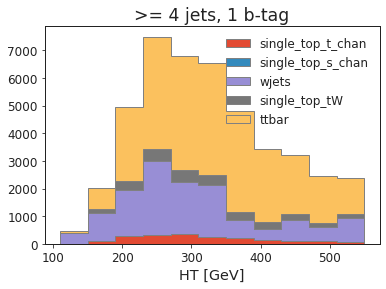

In [10]:
utils.set_style()

all_histograms[120j::hist.rebin(2), "4j1b", :, "nominal"].stack("process")[::-1].plot(stack=True, histtype="fill", linewidth=1, edgecolor="grey")
plt.legend(frameon=False)
plt.title(">= 4 jets, 1 b-tag")
plt.xlabel("HT [GeV]");

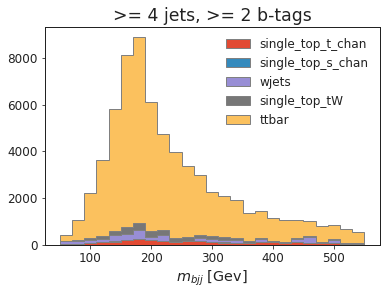

In [11]:
all_histograms[:, "4j2b", :, "nominal"].stack("process")[::-1].plot(stack=True, histtype="fill", linewidth=1,edgecolor="grey")
plt.legend(frameon=False)
plt.title(">= 4 jets, >= 2 b-tags");
plt.xlabel("$m_{bjj}$ [Gev]");

In [12]:
print("4j, >=2b", sum(all_histograms[:, "4j2b", "ttbar", "nominal"].values())) # total before splitting: 101790.4947274355
print("4j, 1b", sum(all_histograms[:, "4j1b", "ttbar", "nominal"].values()))

4j, >=2b 59275.93944114963
4j, 1b 27195.555658935777


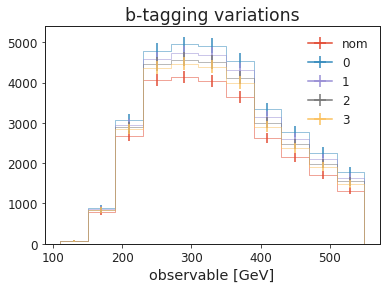

In [13]:
# b-tagging variations
all_histograms[120j::hist.rebin(2), "4j1b", "ttbar", "nominal"].plot(label="nom")
all_histograms[120j::hist.rebin(2), "4j1b", "ttbar", "btag_var_0_down"].plot(label="0")
all_histograms[120j::hist.rebin(2), "4j1b", "ttbar", "btag_var_1_down"].plot(label="1")
all_histograms[120j::hist.rebin(2), "4j1b", "ttbar", "btag_var_2_down"].plot(label="2")
all_histograms[120j::hist.rebin(2), "4j1b", "ttbar", "btag_var_3_down"].plot(label="3")
plt.legend(frameon=False)
plt.title("b-tagging variations");

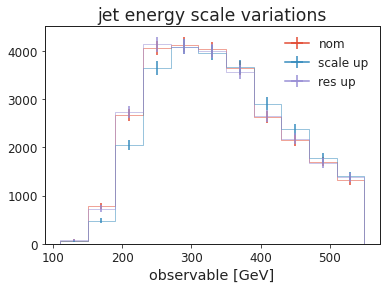

In [14]:
# jet energy scale variations
all_histograms[120j::hist.rebin(2), "4j1b", "ttbar", "nominal"].plot(label="nom")
all_histograms[120j::hist.rebin(2), "4j1b", "ttbar", "pt_scale_up"].plot(label="scale up")
all_histograms[120j::hist.rebin(2), "4j1b", "ttbar", "pt_res_up"].plot(label="res up")
plt.legend(frameon=False)
plt.title("jet energy scale variations");

In [15]:
print(all_histograms[120j::hist.rebin(2), "4j1b", "ttbar", "pt_scale_up"].values() / 3) 
print(all_histograms[120j::hist.rebin(2), "4j1b", "ttbar", "nominal"].values())

[  16.72886344  159.85358394  684.02463827 1217.48950561 1364.33175133
 1323.43897404 1221.20703082  970.27407928  791.8328693   592.94527067
  468.4081762 ]
[  66.91545374  780.68029367 2665.46557412 4065.11381492 4132.02926866
 4037.23237586 3646.89222902 2632.00784725 2146.87080761 1706.34407046
 1316.00392362]


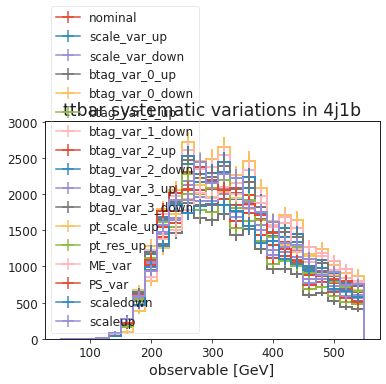

In [16]:
all_histograms[:, "4j1b", "ttbar", :].stack("variation").plot(linewidth=2)
plt.legend()
plt.title("ttbar systematic variations in 4j1b");

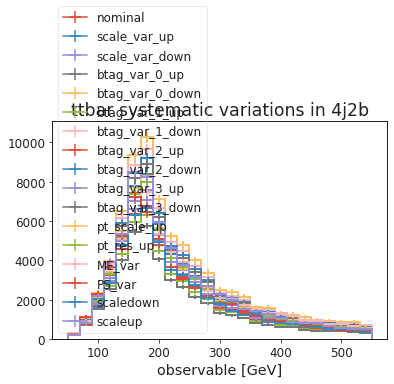

In [17]:
all_histograms[:, "4j2b", "ttbar", :].stack("variation").plot(linewidth=2)
plt.legend()
plt.title("ttbar systematic variations in 4j2b");

### saving histograms & cabinetry

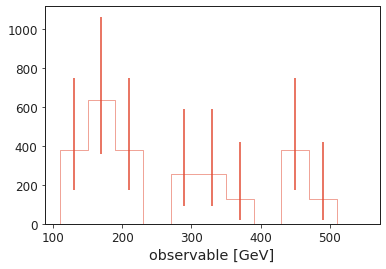

In [18]:
nominal_samples = [sample for sample in fileset.keys() if "nominal" in sample]

all_histograms += 1e-6  # add minimal event count to all bins to avoid crashes when processing a small number of samples

pseudo_data = (all_histograms[:, :, "ttbar", "ME_var"] + all_histograms[:, :, "ttbar", "PS_var"]) / 2  + all_histograms[:, :, "wjets", "nominal"]

with uproot.recreate("histograms.root") as f:
    for region in ["4j1b", "4j2b"]:
        f[f"{region}_pseudodata"] = pseudo_data[120j::hist.rebin(2), region]
        for sample in nominal_samples:
            sample_name = sample.split("__")[0]
            f[f"{region}_{sample_name}"] = all_histograms[120j::hist.rebin(2), region, sample_name, "nominal"]
            
            # b-tagging variations
            for i in range(4):
                for direction in ["up", "down"]:
                    variation_name = f"btag_var_{i}_{direction}"
                    f[f"{region}_{sample_name}_{variation_name}"] = all_histograms[120j::hist.rebin(2), region, sample_name, variation_name]
                
            # jet energy scale variations
            for variation_name in ["pt_scale_up", "pt_res_up"]:
                f[f"{region}_{sample_name}_{variation_name}"] = all_histograms[120j::hist.rebin(2), region, sample_name, variation_name]
            
        f[f"{region}_ttbar_ME_var"] = all_histograms[120j::hist.rebin(2), region, "ttbar", "ME_var"]
        f[f"{region}_ttbar_PS_var"] = all_histograms[120j::hist.rebin(2), region, "ttbar", "PS_var"]
        f[f"{region}_ttbar_scaledown"] = all_histograms[120j::hist.rebin(2), region, "ttbar", "scaledown"]
        f[f"{region}_ttbar_scaleup"] = all_histograms[120j::hist.rebin(2), region, "ttbar", "scaleup"]
        
    hist.Hist(f['4j2b_wjets']).plot()

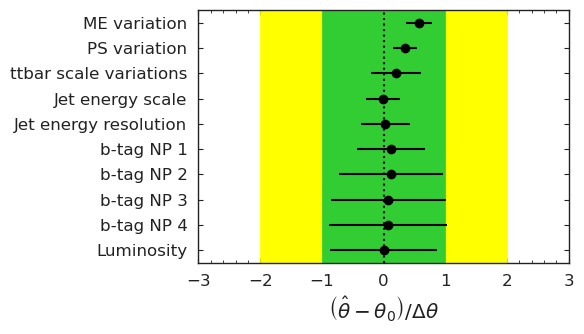

In [19]:
config = cabinetry.configuration.load("config.yml")
cabinetry.templates.collect(config)
cabinetry.templates.postprocess(config)  # optional post-processing (e.g. smoothing)
ws = cabinetry.workspace.build(config)

model, data = cabinetry.model_utils.model_and_data(ws)
fit_results = cabinetry.fit.fit(model, data)

cabinetry.visualize.pulls(
    fit_results, exclude="ttbar_norm", close_figure=True, save_figure=False
)

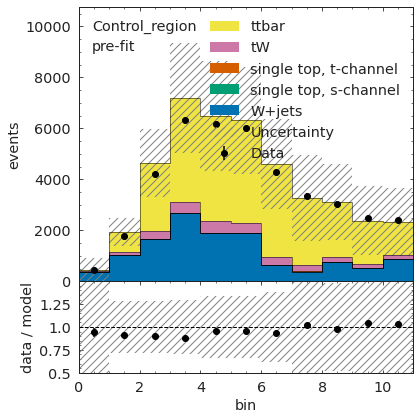

In [20]:
model_prediction = cabinetry.model_utils.prediction(model)
figs = cabinetry.visualize.data_mc(model_prediction, data, close_figure=True)
figs[0]["figure"]

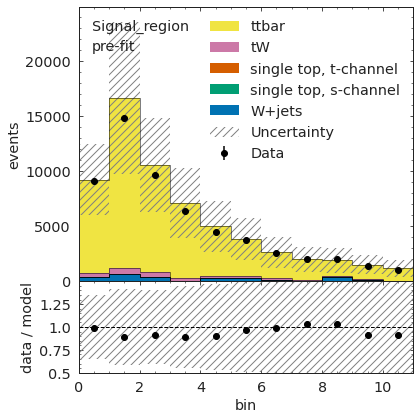

In [21]:
figs[1]["figure"]

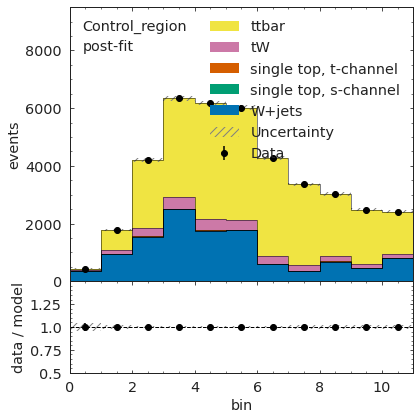

In [22]:
model_prediction_postfit = cabinetry.model_utils.prediction(model, fit_results=fit_results)
figs = cabinetry.visualize.data_mc(model_prediction_postfit, data, close_figure=True)
figs[0]["figure"]

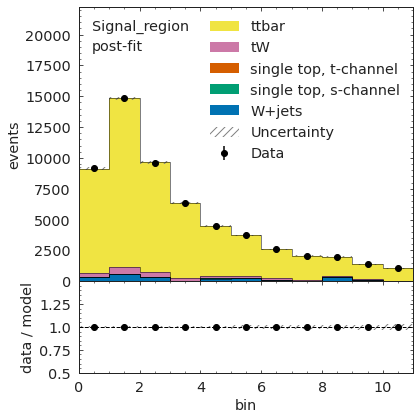

In [23]:
figs[1]["figure"]